In [1]:
%matplotlib inline

In [2]:
import json

import scipy
import networkx as nx
import matplotlib.pyplot as plt

import sklearn.metrics.pairwise

In [3]:
def json_to_edge(json_str):
    edges = []

    tweet = json.loads(json_str)
    this_node = (tweet["user"]["id"], tweet["user"]["screen_name"])

    if ( "retweeted_status" in tweet ):
        rt = tweet["retweeted_status"]
        edges.append(
            (this_node, (rt["user"]["id"], rt["user"]["screen_name"]))
        )
    
    return edges

In [4]:
tweets_bonn = sc.textFile("wri/2017_community_filtered")
tweets_nairobi = sc.textFile("wri/2018_community_filtered")

In [5]:
edge_map = {}

for name, rdd in [
    ("2017", tweets_bonn),
    ("2018", tweets_nairobi),
]:
    
    edges = rdd.flatMap(json_to_edge).map(lambda tup: (tup, 1)).reduceByKey(lambda l, r: l+r)
    edges_collected = edges.collect()
    
    edge_map[name] = edges_collected


In [6]:
graph_map = {}

for name, edges in edge_map.items():
    g = nx.DiGraph()
    nodes = set([tup[0][0] for tup in edges] + [tup[0][1] for tup in edges])
    for nodes_tup in nodes:
        g.add_node(nodes_tup[0], screen_name=nodes_tup[1])

    for edge in edges:
        weight = edge[1]
        nodes = edge[0]
        left = nodes[0]
        right = nodes[1]

        g.add_edge(left[0], right[0], weight=weight)
        
    graph_map[name] = g

In [7]:
for name, g in graph_map.items():
    nx.write_graphml(g, "%s_retweets.graphml" % name)

In [8]:
graph_map = {
    "2017": nx.read_graphml("2017_retweets.graphml"),
    "2018": nx.read_graphml("2018_retweets.graphml")
}

In [31]:
min_degree = 3

In [32]:
g = graph_map["2018"].to_undirected()
subg_nodes = [k for k,v in g.degree() if v >= min_degree]
subg = nx.subgraph(g, subg_nodes)

print("Node REduction:", len(g.nodes), len(subg.nodes))

comms = nx.community.greedy_modularity_communities(subg)

Node REduction: 23132 15977


In [33]:
with open("2018_rt_comm_assigns.json", "w") as out_file:
    json.dump([list(x) for x in comms], out_file)

In [34]:
g = graph_map["2017"].to_undirected()
subg_nodes = [k for k,v in g.degree() if v >= min_degree]
subg = nx.subgraph(g, subg_nodes)

print("Node REduction:", len(g.nodes), len(subg.nodes))

comms = nx.community.greedy_modularity_communities(subg)

with open("2017_rt_comm_assigns.json", "w") as out_file:
    json.dump([list(x) for x in comms], out_file)

Node REduction: 9441 6648


In [35]:
# sc.stop()

In [36]:
comms_map = {}

with open("2017_rt_comm_assigns.json", "r") as in_file:
    comms_map["2017"] = json.load(in_file)
with open("2018_rt_comm_assigns.json", "r") as in_file:
    comms_map["2018"] = json.load(in_file)

In [37]:
node_id_to_name = {}
for name, graph in graph_map.items():
    for node, node_data in graph.nodes(data=True):
        node_id_to_name[node] = node_data["screen_name"]

In [38]:
node_id_set = set()
for name, comms in comms_map.items():
    for comm in comms:
        for u in comm:
            node_id_set.add(u)
            
node_id_idx = {uid:idx for idx, uid in enumerate(node_id_set)}

In [39]:
len(node_id_idx)

20479

In [50]:
comms_matrics = {}
for name, comms in comms_map.items():
    print("Graph:", name)
    data = []
    coords = []
    
    g = graph_map[name]
    row = 0
    for comm in comms:
        if ( len(comm) < 100 ):
            continue
            
        print("Comm:", row, "Comm Size:", len(comm))
            
        subg = nx.subgraph(g, comm)
        
        page_rank = nx.pagerank(subg)
        for u, score in page_rank.items():
            col = node_id_idx[u]
            coords.append((row, col))
            data.append(score)

        top_ = [(x, page_rank[x]) 
                for x in sorted(page_rank, key=page_rank.get, reverse=True)[:20]]
        for x in [node_id_to_name[x] for x, r in top_]:
            print("\t", x)
            
        row += 1
        
    mat = scipy.sparse.csr_matrix(
        (data, ([x[0] for x in coords], [x[1] for x in coords])),
        shape=(row, len(node_id_idx))
    )
    comms_matrics[name] = mat

Graph: 2017
Comm: 0 Comm Size: 3159
	 BiancaJagger
	 GlobalLF
	 CIFOR
	 restoreforward
	 FAOForestry
	 mongabay
	 rbw66
	 RoathBrookTrees
	 FTA_CGIAR
	 nspugh
	 Connect4Climate
	 FAO
	 raringtoread
	 streettreeart
	 WorldResources
	 TCHSunderland
	 UNBiodiversity
	 BioversityInt
	 seasonalight
	 CIFOR_bosques
Comm: 1 Comm Size: 2779
	 UNFCCC
	 UNEnvironment
	 WorldBank
	 PEspinosaC
	 ErikSolheim
	 AfrozShah1
	 KGeorgieva
	 JimYongKim
	 WBG_Climate
	 EmmanuelMacron
	 WHO
	 antonioguterres
	 LewisPugh
	 GlobalGoalsUN
	 UN
	 ibrahimthiaw
	 BNPParibas
	 COP23
	 UNDPClimate
	 volvooceanrace
Comm: 2 Comm Size: 434
	 SadhguruJV
	 ishafoundation
	 dw_environment
	 IshaTamil
	 jmollins
	 rallyforrivers
	 vishwamTOI
	 inner_elation
	 Arindam_Basu
	 IshaUSA
	 abi_tweeting
	 Jeeva04
	 RohitJain700
	 NiranjanAjit
	 nanowellbeing
	 tree_adoptionug
	 EllenGoddard1
	 RaviiRaghu
	 bigfundu
	 IshaAndrewJ
Comm: 3 Comm Size: 135
	 ILuvCO2
	 GillesnFio
	 miked194765
	 JWSpry
	 climatechangede
	 FriendsOSci

In [41]:
sim_mat = sklearn.metrics.pairwise.cosine_similarity(
    comms_matrics["2017"], comms_matrics["2018"]
)

sim_mat

array([[  1.57749836e-01,   3.06791278e-03,   1.00704583e-03,
          0.00000000e+00],
       [  7.73882573e-01,   1.38327826e-01,   1.61239287e-04,
          0.00000000e+00],
       [  1.27867662e-03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.48516835e-05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]])

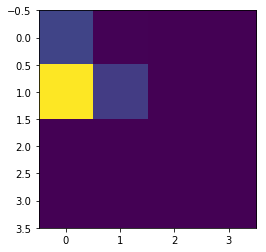

In [43]:
plt.imshow(sim_mat)

plt.show()

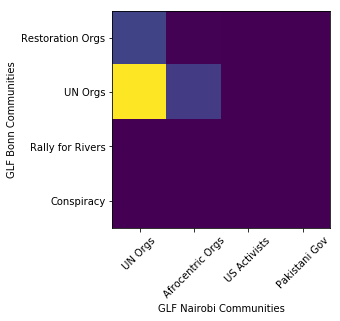

In [52]:
row_labels = ["Restoration Orgs", "UN Orgs", "Rally for Rivers", "Conspiracy"]
col_labels = ["UN Orgs", "Afrocentric Orgs", "US Activists", "Pakistani Gov"]

plt.imshow(sim_mat)

plt.yticks(range(len(row_labels)), row_labels)
plt.xticks(range(len(col_labels)), col_labels, rotation=45)

plt.xlabel("GLF Nairobi Communities")
plt.ylabel("GLF Bonn Communities")

plt.show()